In [147]:
import time
import numpy as np
from sklearn.datasets import make_classification, make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from scipy.optimize import minimize

# Generate dataset

In [203]:
X, y = make_classification( n_samples=2502, 
                            random_state=259202,
                            n_features=2, 
                            n_informative=2, 
                            n_redundant=0, 
                            n_repeated=0, 
                            class_sep=2)
Xm, ym = make_moons(n_samples=2502, random_state=259202)

In [204]:
X.shape, y.shape, Xm.shape, ym.shape

((2502, 2), (2502,), (2502, 2), (2502,))

In [205]:
def plot_data(X, y, title=""):
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
    plt.title(title)
    plt.show()

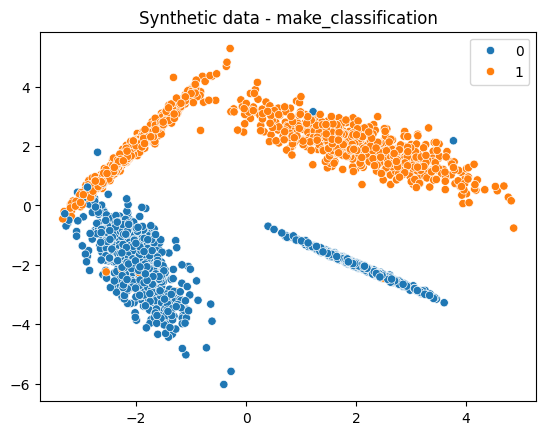

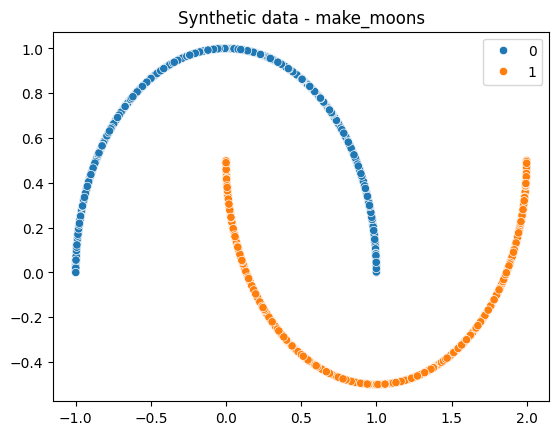

In [206]:
plot_data(X, y, "Synthetic data - make_classification")
plot_data(Xm, ym, "Synthetic data - make_moons")

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=295202)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, random_state=295202)

In [260]:
def plot_decision_boundary(X, y, w, b, title=""):
    h = 0.02
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = b + w[0] * xx + w[1] * yy
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show() 

In [208]:
def plot_decision_boundary_clf(X, y, clf, title=""):
    h = 0.02
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show() 

# Implementation of linear SVM

In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_moons = StandardScaler()
Xm_train_scaled = scaler_moons.fit_transform(Xm_train)
Xm_test_scaled = scaler_moons.transform(Xm_test)

In [246]:
y_train_scaled = np.where(y_train == 1, 1, -1)
ym_train_scaled = np.where(ym_train == 1, 1, -1)
y_train_scaled, ym_train_scaled

(array([ 1,  1, -1, ...,  1, -1,  1]), array([ 1, -1,  1, ...,  1, -1, -1]))

In [247]:
X_train_scaled.shape, y_train_scaled.shape

((1876, 2), (1876,))

In [248]:
K = X_train_scaled @ X_train_scaled.T
Y = y_train_scaled.reshape(-1, 1) @ y_train_scaled.reshape(-1, 1).T
K.shape, Y.shape

((1876, 1876), (1876, 1876))

In [ ]:
n = X_train_scaled.shape[0]
YK = Y * K 

def obj(lam):
    # dual: L(lam) = sum(lam) − 0.5 * lam @ (Y*K) lam
    return -(lam.sum() - 0.5 * lam @ YK @ lam)

cons = {'type': 'eq', 'fun': lambda lam: lam @ y_train_scaled} # ensure sum(lam_i * y_i) = 0
bounds = [(0, None)] * n 

# initial guess
lam0 = np.ones(n)

res = minimize(obj,
               x0=lam0,
               bounds=bounds,
               constraints=cons,
               options={'maxiter':5, 'disp':True})

Iteration limit reached    (Exit mode 9)
            Current function value: -68036.45416388262
            Iterations: 5
            Function evaluations: 9389
            Gradient evaluations: 5


In [ ]:
lams = res.x

# support vectors mask
sv = lams > 1e-6

w = (lams * y_train_scaled) @ X_train_scaled
b = np.mean(y_train_scaled[sv] - X_train_scaled[sv] @ w)

def predict(X): 
    return np.sign(X @ w + b) # -1 or 1

def predict_proba(X): 
    return (X @ w + b) # probability

y_test_scaled = np.where(y_test==1, 1, -1)
y_pred = predict(X_test_scaled)

accuracy_impl = accuracy_score(y_test_scaled, y_pred)
print(f"Implemented SVM accuracy: {accuracy_impl}")

Implemented SVM accuracy: 0.9840255591054313


In [254]:
def train_impl_svm(X_train, y_train, maxiter=5):

    y = np.where(y_train == 1, 1, -1)
    n = X_train.shape[0]
    K = X_train @ X_train.T
    Y = y.reshape(-1,1) @ y.reshape(1,-1)
    YK = Y * K

    def obj(lam):
        # dual objective (negated for minimizer)
        return -(lam.sum() - 0.5 * lam @ YK @ lam)

    cons = {'type':'eq', 'fun': lambda lam: lam @ y}
    bounds = [(0, None)] * n
    lam0 = np.ones(n)

    res = minimize(obj,
                   x0=lam0,
                   bounds=bounds,
                   constraints=cons,
                   options={'maxiter': maxiter, 'disp': False})
    lams = res.x
    sv_mask = lams > 1e-6

    w = (lams * y) @ X_train
    b = np.mean(y[sv_mask] - X_train[sv_mask] @ w)

    return {'w': w, 'b': b, 'lams': lams, 'sv': sv_mask, 'opt_res': res}


def predict_impl_svm(model, X):
    scores = X @ model['w'] + model['b']
    return np.sign(scores), scores

In [263]:
model = train_impl_svm(X_train_scaled, y_train)
model_moons = train_impl_svm(Xm_train_scaled, ym_train)

In [269]:
y_test_scaled = np.where(y_test==1, 1, -1)
ym_test_scaled = np.where(ym_test==1, 1, -1)

y_pred_impl, y_score_impl = predict_impl_svm(model, X_test_scaled)
accuracy_impl = accuracy_score(y_test_scaled, y_pred_impl)

y_pred_impl_moons, y_score_impl_moons = predict_impl_svm(model_moons, Xm_test_scaled)
accuracy_impl_moons = accuracy_score(ym_test_scaled, y_pred_impl_moons)

print("Implemented SVM accuracy make_classification:", accuracy_impl)
print("Implemented SVM accuracy make_moons:", accuracy_impl_moons)

Implemented SVM accuracy make_classification: 0.9840255591054313
Implemented SVM accuracy make_moons: 0.7571884984025559


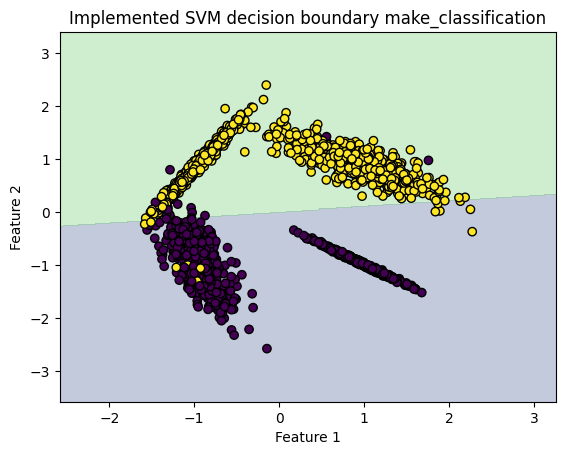

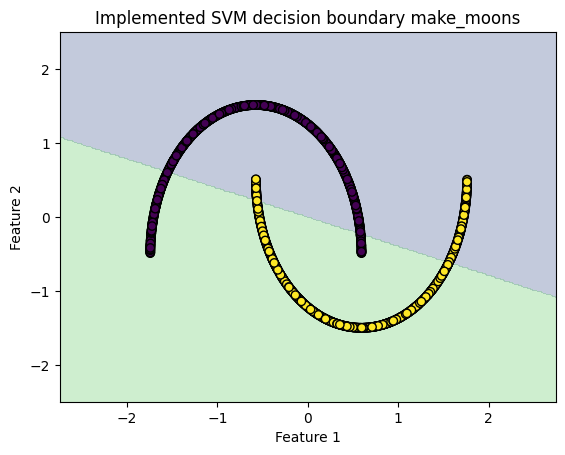

In [267]:
plot_decision_boundary(X_train_scaled, y_train_scaled, model['w'], model['b'], title="Implemented SVM decision boundary make_classification")
plot_decision_boundary(Xm_train_scaled, ym_train_scaled, model_moons['w'], model_moons['b'], title="Implemented SVM decision boundary make_moons")

# Sklearn SVM SVC

kerlen = linear

In [271]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf.fit(X_train, y_train)
y_pred_skl = clf.predict(X_test)
y_score_skl = clf.decision_function(X_test)
accuracy_skl = accuracy_score(y_test, y_pred_skl)

clfm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clfm.fit(Xm_train, ym_train)
ym_pred_skl = clfm.predict(Xm_test)
ym_score_skl = clfm.decision_function(Xm_test)
accuracy_skl_moons = accuracy_score(ym_test, ym_pred_skl)

In [272]:
print(f"Accuracy score SVC - make_classification: {accuracy_skl}")
print(f"Accuracy score SVC - make_moons: {accuracy_skl_moons}")

Accuracy score SVC - make_classification: 0.9952076677316294
Accuracy score SVC - make_moons: 0.8945686900958466


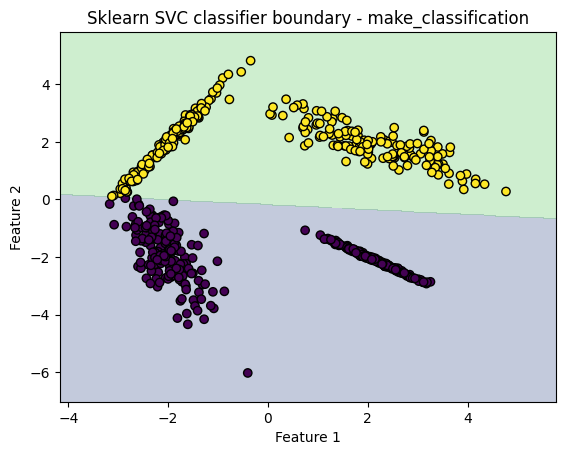

In [273]:
plot_decision_boundary_clf(X_test, y_pred_skl, clf, "Sklearn SVC classifier boundary - make_classification")

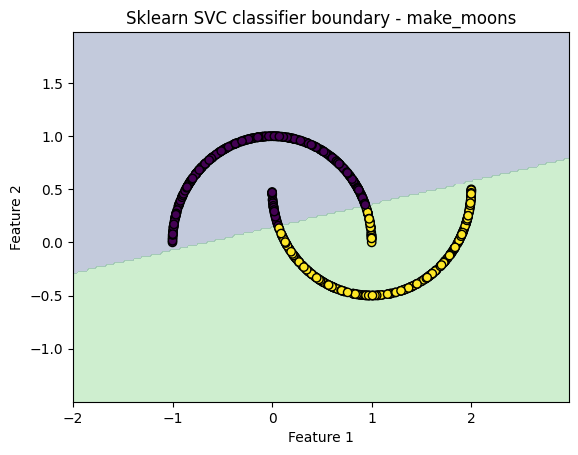

In [274]:
plot_decision_boundary_clf(Xm_test, ym_pred_skl, clfm, "Sklearn SVC classifier boundary - make_moons")

# Evaluation

In [ ]:
start_time = time.time()
for _ in range(10):
    clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    clf.fit(X_train, y_train)
sklearn_time = time.time() - start_time

start_time = time.time()
for _ in range(10):
    _ = train_impl_svm(X_train_scaled, y_train)
implemented_time = time.time() - start_time

In [ ]:
print(f"Sklearn time: {sklearn_time:.6f} s")
print(f"Implemented time: {implemented_time:.6f} s")

Sklearn time: 0.000999 s


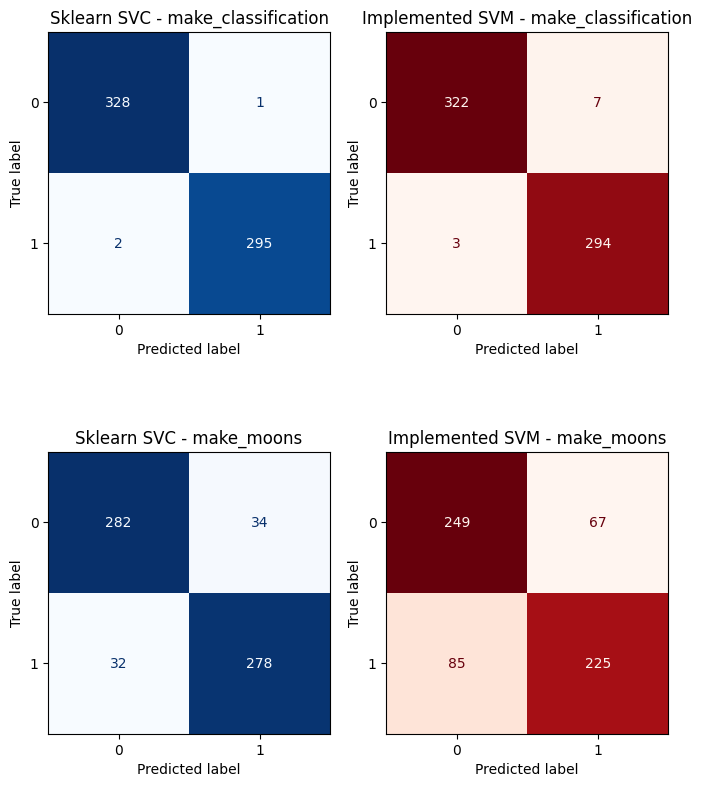

In [283]:
figure, axes = plt.subplots(2, 2, figsize=(8,10))

# make_classification dataset
cm_skl = confusion_matrix(y_test, y_pred_skl)
disp_skl = ConfusionMatrixDisplay(cm_skl)
disp_skl.plot(ax=axes[0,0], cmap='Blues', colorbar=None)
axes[0,0].set_title("Sklearn SVC - make_classification")

cm_impl = confusion_matrix(y_test_scaled, y_pred_impl)
disp_impl = ConfusionMatrixDisplay(cm_impl)
disp_impl.plot(ax=axes[0,1], cmap='Reds', colorbar=None)
axes[0,1].set_title("Implemented SVM - make_classification")

# make_moons dataset
cm_skl_m = confusion_matrix(ym_test, ym_pred_skl)
disp_skl_m = ConfusionMatrixDisplay(cm_skl_m)
disp_skl_m.plot(ax=axes[1,0], cmap='Blues', colorbar=None)
axes[1,0].set_title("Sklearn SVC - make_moons")

cm_impl_m = confusion_matrix(ym_test_scaled, y_pred_impl_moons)
disp_impl_m = ConfusionMatrixDisplay(cm_impl_m)
disp_impl_m.plot(ax=axes[1,1], cmap='Reds', colorbar=None)
axes[1,1].set_title("Implemented SVM - make_moons")

# plt.tight_layout()
plt.show()

In [284]:
name = ["Sklearn make_classification", "Sklearn moons", "Implemented make_classification", "Implemented moons"]
for i, cm in enumerate([cm_skl, cm_skl_m, cm_impl, cm_impl_m]):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn+fp) # swoistosc
    sensitivity = tp / (tp+fn) # czulosc
    print(name[i])
    print(f"specificity: {specificity}")
    print(f"sensitivity: {sensitivity}\n")

Sklearn make_classification
specificity: 0.9969604863221885
sensitivity: 0.9932659932659933

Sklearn moons
specificity: 0.8924050632911392
sensitivity: 0.896774193548387

Implemented make_classification
specificity: 0.9787234042553191
sensitivity: 0.98989898989899

Implemented moons
specificity: 0.7879746835443038
sensitivity: 0.7258064516129032



In [285]:
# make_classification
fpr_skl, tpr_skl, _ = roc_curve(y_test, y_score_skl)
auc_skl = auc(fpr_skl, tpr_skl)

fpr_impl, tpr_impl, _ = roc_curve(y_test_scaled, y_score_impl)
auc_impl = auc(fpr_impl, tpr_impl)

# make_moons
fpr_skl_m, tpr_skl_m, _ = roc_curve(ym_test, ym_score_skl)
auc_skl_m = auc(fpr_skl_m, tpr_skl_m)

fpr_impl_m, tpr_impl_m, _ = roc_curve(ym_test_scaled, y_score_impl_moons)
auc_impl_m = auc(fpr_impl_m, tpr_impl_m)

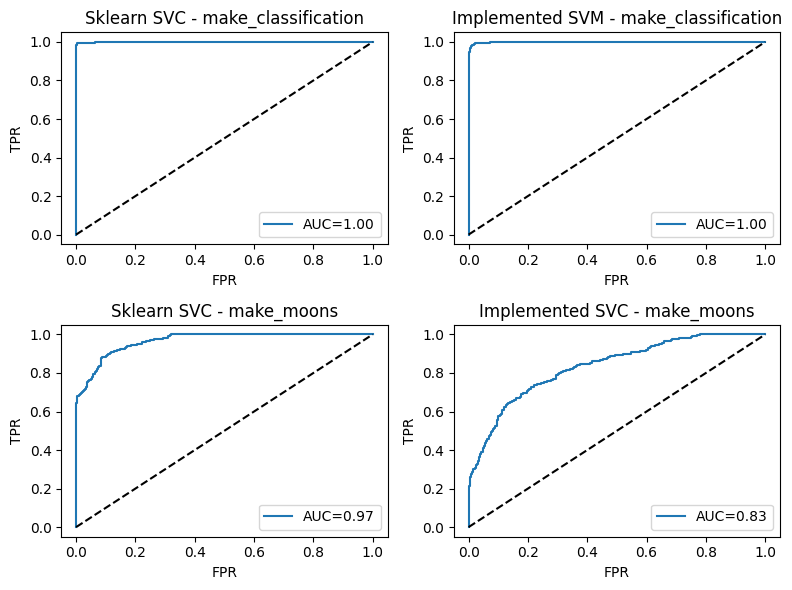

In [291]:
fig, axes = plt.subplots(2, 2, figsize=(8,6))

axes[0,0].plot(fpr_skl, tpr_skl, label=f"AUC={auc_skl:.2f}")
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_title("Sklearn SVC - make_classification")
axes[0,0].set_xlabel("FPR")
axes[0,0].set_ylabel("TPR")
axes[0,0].legend(loc="lower right")

axes[0,1].plot(fpr_impl, tpr_impl, label=f"AUC={auc_impl:.2f}")
axes[0,1].plot([0,1],[0,1],'k--')
axes[0,1].set_title("Implemented SVM - make_classification")
axes[0,1].set_xlabel("FPR")
axes[0,1].set_ylabel("TPR")
axes[0,1].legend(loc="lower right")

axes[1,0].plot(fpr_skl_m, tpr_skl_m, label=f"AUC={auc_skl_m:.2f}")
axes[1,0].plot([0,1],[0,1],'k--')
axes[1,0].set_title("Sklearn SVC - make_moons")
axes[1,0].set_xlabel("FPR")
axes[1,0].set_ylabel("TPR")
axes[1,0].legend(loc="lower right")

axes[1,1].plot(fpr_impl_m, tpr_impl_m, label=f"AUC={auc_impl_m:.2f}")
axes[1,1].plot([0,1],[0,1],'k--')
axes[1,1].set_title("Implemented SVC - make_moons")
axes[1,1].set_xlabel("FPR")
axes[1,1].set_ylabel("TPR")
axes[1,1].legend(loc="lower right")

plt.tight_layout()
plt.show()